# Submodule 1: Introduction to genome sequencing and assembly
--------
Genomics is the comprehensive study of an organism's complete set of DNA, including all of its genes. It provides a deep understanding of the genetic blueprint that governs the biology, function, and behavior of organisms. 

With the advent of advanced sequencing technologies, genomics has become an essential tool for exploring the genetic basis of health and disease, understanding evolution, and studying biodiversity. A critical component of genomics is genome assembly, which involves reconstructing the genome of an organism from short DNA sequences generated by sequencing technologies. Genome assembly is a foundational step that allows researchers to generate a complete picture of the genetic material in a given organism. Assessing the quality and completeness of a genome assembly ensures that it accurately reflects the original genome, providing a reliable foundation for further analysis.

Comparative genomics builds on genome assembly by comparing the genomes of different species or individuals. This field focuses on identifying similarities and differences in DNA sequences to understand evolutionary relationships, discover conserved genetic elements, and reveal the genetic underpinnings of adaptation and diversity. Comparative genomics can uncover how species evolve and adapt over time and identify genes associated with specific traits or diseases.

In this tutorial, we will explore the key concepts and methodologies in genomics, including how to assemble a genome, assess its quality, and perform comparative analyses. Through hands-on examples, you will learn how to analyze genomic data, interpret results, and apply various computational tools to gain deeper insights into the genetic information that defines life.

 

### Learning Objectives:

+ Understand how high throughput sequencing data is generated. 

+ Develop an understanding of core bioinformatic input/output formats as it relates to comparative genomics. 

+ Acquire the skills to assemble raw sequencing reads into a draft genome, assess the quality of the genome assembly, and annotate the genome sequence. 

+ Learn to perform comparative genomic analyses to identify similarities and differences across genomes, run phylogenomic analyses, construct pangenomes to capture genetic diversity, and apply these techniques to address biological questions and hypotheses. 

## 1.1 - Generation of sequencing data

Isolate Bacteria            |  Extract DNA
:-------------------------:|:-------------------------:
![alt text](https://github.com/Joseph7e/HCGS-Genomics-Tutorial/blob/master/petri.jpg?raw=true)  |  <img src="https://www.cephamls.com/wp-content/uploads/2019/02/DNA-Extraction-Figure-3-22.jpg" width="420">
<img src="https://github.com/Joseph7e/HCGS-Genomics-Tutorial/blob/master/fragmentation3.png?raw=true" width="800">

Prepare Library           |  Sequence DNA
:-------------------------:|:-------------------------:
<img src="https://jef.works//assets/blog/librarystructure.png" width="520">  |  <img src="https://github.com/Joseph7e/HCGS-Genomics-Tutorial/blob/master/hiseq.png?raw=true" width="320">

## 1.2 - How next-generation sequencing works

[![sequencing by synthesis](img/youtube-video-sequencing.PNG)](https://www.youtube.com/watch?v=p4vKJJlNTKA&t=9s "Sequencing")

### 1.2.1 Cost of generating sequencing data

CItation: Wetterstrand KA. DNA Sequencing Costs: Data from the NHGRI Genome Sequencing Program (GSP) Available at: www.genome.gov/sequencingcostsdata. Accessed [10/03/2024].

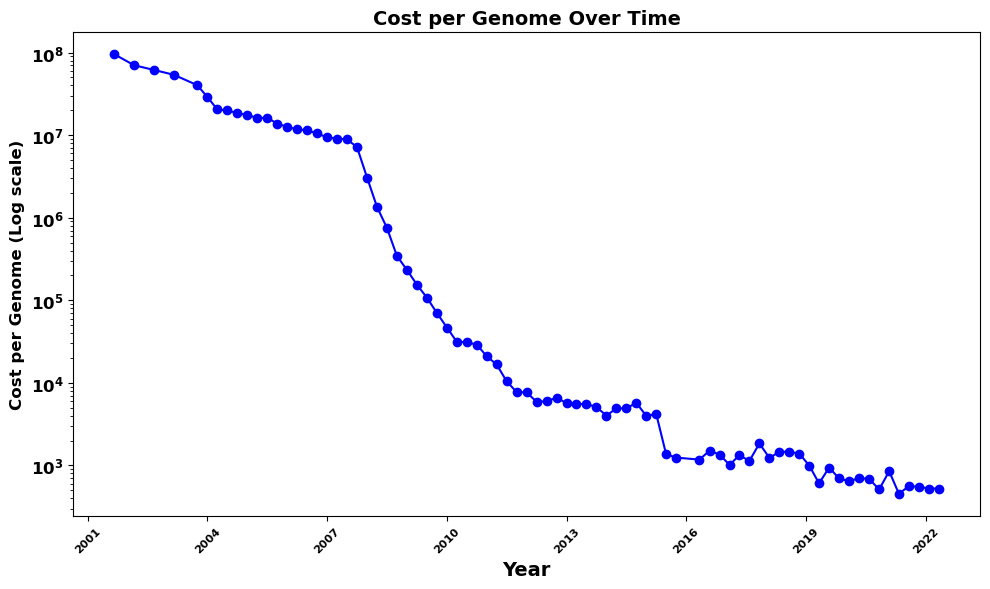

In [37]:
### 1.2.2 Generate plot showing the cost of sequencing genomes over time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the CSV file
data_table = "data/Sequencing_Cost_Data_Table_May2022.csv"
df = pd.read_csv(data_table)

# Convert the 'Date' column to datetime format using YYYY-MM
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')

# Clean up 'Cost per Genome' column by removing $ and commas, and converting to numeric
df['Cost per Genome'] = df['Cost per Genome'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Plot the data
plt.figure(figsize=(10, 6))

# X-axis: Date, Y-axis: Cost per Genome in log scale
plt.plot(df['Date'], df['Cost per Genome'], marker='o', linestyle='-', color='b')

# Set log scale for y-axis
plt.yscale('log')

# Set labels and title
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Cost per Genome (Log scale)', fontsize=12, fontweight='bold')
plt.title('Cost per Genome Over Time', fontsize=14, fontweight='bold')

# Format the x-axis for better date presentation
import matplotlib.dates as mdates

# Set major ticks to display years at specific intervals
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))  # Adjust the number here for the interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate and format x-ticks
plt.xticks(rotation=45, fontsize=8, fontweight='bold')


# Set the y-axis limits from $100 to $100,000
# plt.ylim(100, 0000)
plt.yticks(fontsize=12, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.savefig("cost_per_genome_plot.png", dpi=300)
plt.show()

## 1.3 - Comparison of sequencing instruments

## 1.4 - Starting data

Each of these samples represent the genome of a unique and novel microbe that has not been seen before (except by me). 

The data utilized in this tutorial was generated by Illumina HiSeq 2500, is paired-end and each read is 250 bps n length. 

<p align="center">
    <img src="images/jupyterNotebook_annotated.png" alt="jupyterNotebook" width="50%"/>
</p>

### 1.4.1 - Install sra-tools to access public data available on the NCBI Sequence Read Archive (SRA)

In [14]:
%%bash

# Install fastq-dump using mamba ( a conda alternative)
mamba install --channel bioconda python=3.9 sra-tools -y > /dev/null 2>&1

# hide standard error and standard out > /dev/null 2>&1
# hide standard error only 2> /dev/null

echo "Installation of sra-tools complete"

bioconda/linux-64                                           Using cache
bioconda/noarch                                             Using cache
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
nvidia/linux-64                                             Using cache
nvidia/noarch                                               Using cache
pytorch/linux-64                                            Using cache
pytorch/noarch                                              Using cache
Transaction

  Prefix: /home/ec2-user/anaconda3/envs/python3

  All requested packages already installed


Looking for: ['python=3.9', 'sra-tools']

Installation of sra-tools complete


In [7]:
%%bash

# setup working directory and move into it
mkdir wgs-workflow
cd wgs-workflow

# Capture the SRA accession in a variable 
accession=SRR10056829

# Download data from the SRA using the variable from above 

# prefetching downloads metadata of the SRA records (5.629s)
prefetch -v $accession

# fastq-dump downlaods the reads and compresses them using standard gzip compression. (1m33.96s)
fastq-dump --outdir raw-reads --gzip --split-files "$accession"/"$accession".sra

# Remove the prefetch directory
rm -r $accession

mkdir: cannot create directory ‘wgs-workflow’: File exists


2024-09-30T14:49:15 prefetch.3.1.1: 1) Resolving 'SRR10056829'...
2024-09-30T14:49:15 prefetch.3.1.1: 'tools/ascp/disabled': not found in configuration
2024-09-30T14:49:15 prefetch.3.1.1: Checking 'ascp'
2024-09-30T14:49:15 prefetch.3.1.1: 'ascp': not found
2024-09-30T14:49:15 prefetch.3.1.1: Checking 'ascp'
2024-09-30T14:49:15 prefetch.3.1.1: 'ascp': not found
2024-09-30T14:49:15 prefetch.3.1.1: Checking '/usr/bin/ascp'
2024-09-30T14:49:15 prefetch.3.1.1: '/usr/bin/ascp': not found
2024-09-30T14:49:15 prefetch.3.1.1: Checking '/usr/bin/ascp'
2024-09-30T14:49:15 prefetch.3.1.1: '/usr/bin/ascp': not found
2024-09-30T14:49:15 prefetch.3.1.1: Checking '/opt/aspera/bin/ascp'
2024-09-30T14:49:15 prefetch.3.1.1: '/opt/aspera/bin/ascp': not found
2024-09-30T14:49:15 prefetch.3.1.1: Checking '/opt/aspera/bin/ascp'
2024-09-30T14:49:15 prefetch.3.1.1: '/opt/aspera/bin/ascp': not found
2024-09-30T14:49:15 prefetch.3.1.1: Checking '/home/ec2-user/.aspera/connect/bin/ascp'
2024-09-30T14:49:15 prefe

### 1.4.2 - FASTQ file format
These data are in **FASTQ** format (see below).

[Link explaining the 'Read Name Format'](http://support.illumina.com/content/dam/illumina-support/help/BaseSpaceHelp_v2/Content/Vault/Informatics/Sequencing_Analysis/BS/swSEQ_mBS_FASTQFiles.htm): SampleName_Barcode_LaneNumber_001.fastq.gz


Important note: In the above command I use the "\*" character to view the Sample directory, I would normally just type out the entire path using tab complete (which is what you should do). This wildcard will match any string of characters. I use this because everyone will have a different Sample name. To make this tutorial as general as possible I need to use these wildcards throughout the tutorial. In addition I may use Sample_X instead of Sample_\*. In these cases be sure to type out your complete sample name!, the wildcards probably won't work 

In [12]:
%%bash

# If the above code worked you should have two FASTQ files in a directory called raw-reads
ls raw-reads/

# Pull the raw fastq files you need from the SRA
zcat raw-reads/SRR10056829_1.fastq.gz | head -n 4

SRR10056829_1.fastq.gz
SRR10056829_2.fastq.gz
@SRR10056829.1 1 length=100
NCCCCAAGGAATAACATTCATAACCCCCATAGCCGAAGTAATAATCAATAACATTGAAGTCTTTCTTATACCTAAACGCTCATAAATAGGTAATAATGCA
+SRR10056829.1 1 length=100
#0<FFFFFFFFFFIIFFIIIIIIFIIIIIIIIIFIFFIIIIIIIIFFFIIIIIIIIFIIIIIIIIIIFFFFFFFBFFFFFFFFFFFFFBFBBFFFFFFFF


## 1.5 - Quality assessment


### 1.5.1 Do we have enough coverage? How do we determine our total throughput?

INSERT FLASH CARD WITH QUESTIONS ABOUT READ LENGTH AND COVERAGE

In [15]:
%%bash

# counting the lines and dividing by 4. Remember each read entry is exactly four lines long. These numbers should match.
zcat raw-reads/*_1.fastq.gz | wc -l

6365120


In [19]:
%%bash

# we can do this calculation from the terminal with echo and bc (bc is the terminal calculator)
num_reads=6365120
read_length=250
genome_size=5000000

# calculate our total throughput
echo "Total number of base pairs sequenced"
throughput=$(echo $num_reads " * " $read_length " * 2" | bc)
echo $throughput

# calculate our estimated coverage
echo "Total coverage for genome dataset"
est_coverage=$(echo $throughput " / " 


Total number of base pairs sequenced
3182560000



### 1.5.2 Quality Assessment with FASTQC

Program: FASTQC
Manual: https://www.bioinformatics.babraham.ac.uk/projects/fastqc/
FASTQC explained:
Conda:

FastQC is a program to summarize read qualities and base composition. Since we have millions of reads there is no practical way to do this by hand. We call the program to parse through the fastq files and do the hard work for us. The input to the program is one or more fastq file(s) and the output is an html file with several figures. The link above describes what each of the output figures are describing. I mainly focus on the first graph which visualizes our average read qualities and the last figure which shows the adapter content. Note that this program does not do anything to your data, as with the majority of the assessment tools, it merely reads it.

In [21]:
%%bash
# Install fastqc using mamba ( a conda alternative)
mamba install --channel bioconda python=3.9 fastqc -y > /dev/null 2>&1

# > /dev/null 2>&1 : hides standard error and standard out 
# 2> /dev/null : hides standard error only 

echo "Installation of fastqc complete"
fastqc --version

Transaction

  Prefix: /home/ec2-user/anaconda3/envs/python3

  Updating specs:

   - python=3.9
   - fastqc
   - ca-certificates
   - certifi
   - openssl


  Package       Version  Build       Channel           Size
─────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────

  + xorg-libxt    1.3.0  hd590300_1  conda-forge     Cached
  + openjdk      22.0.1  h8651b0f_1  conda-forge      182MB
  + fastqc       0.12.1  hdfd78af_0  bioconda          12MB

  Summary:

  Install: 3 packages

  Total download: 193MB

─────────────────────────────────────────────────────────────



Looking for: ['python=3.9', 'fastqc']



Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Installation of fastqc complete
FastQC v0.12.1


In [24]:
%%bash
# make a directory to store the output
mkdir output-fastqc

# run the program on the two read files (R1 and R2).
fastqc raw-reads/*.fastq.gz -o output-fastqc --threads 24

# the resulting folder should contain a zipped archive and an html file, we can ignore the zipped archive which is redundant.
ls output-fastqc/

mkdir: cannot create directory ‘output-fastqc’: File exists


application/gzip
application/gzip


Started analysis of SRR10056829_1.fastq.gz
Started analysis of SRR10056829_2.fastq.gz
Approx 5% complete for SRR10056829_2.fastq.gz
Approx 5% complete for SRR10056829_1.fastq.gz
Approx 10% complete for SRR10056829_2.fastq.gz
Approx 10% complete for SRR10056829_1.fastq.gz
Approx 15% complete for SRR10056829_2.fastq.gz
Approx 15% complete for SRR10056829_1.fastq.gz
Approx 20% complete for SRR10056829_2.fastq.gz
Approx 20% complete for SRR10056829_1.fastq.gz
Approx 25% complete for SRR10056829_1.fastq.gz
Approx 25% complete for SRR10056829_2.fastq.gz
Approx 30% complete for SRR10056829_1.fastq.gz
Approx 30% complete for SRR10056829_2.fastq.gz
Approx 35% complete for SRR10056829_1.fastq.gz
Approx 35% complete for SRR10056829_2.fastq.gz
Approx 40% complete for SRR10056829_1.fastq.gz
Approx 40% complete for SRR10056829_2.fastq.gz
Approx 45% complete for SRR10056829_1.fastq.gz
Approx 45% complete for SRR10056829_2.fastq.gz
Approx 50% complete for SRR10056829_1.fastq.gz
Approx 50% complete for

Analysis complete for SRR10056829_1.fastq.gz
Analysis complete for SRR10056829_2.fastq.gz
SRR10056829_1_fastqc.html
SRR10056829_1_fastqc.zip
SRR10056829_2_fastqc.html
SRR10056829_2_fastqc.zip


In [ ]:
### view HTML report
from IPython.display import HTML


## 1.6 - Quality and adapter trimming with FASTP

Program: fastp - an ultra-fast all-in-one FASTQ preprocessor
Citation: *Chen, S. (2023). Ultrafast one‐pass FASTQ data preprocessing, quality control, and deduplication using fastp. Imeta, 2(2), e107.*
Manual: https://github.com/OpenGene/fastp
Conda: https://anaconda.org/bioconda/fastp

Description:
Ultrafast one-pass FASTQ data preprocessing, quality control, and deduplication.

In [ ]:
%%bash
# Install fastp using mamba (a conda alternative)
mamba install --channel bioconda python=3.9 fastp -y > /dev/null 2>&1

# hide standard error and standard out > /dev/null 2>&1
# hide standard error only 2> /dev/null

fastp --version
echo "Installation Complete"

In [7]:
%%bash

# make a directory to store the output
mkdir output-fastp

# define input variables
forward=raw-reads/SRR10056829_1.fastq.gz
reverse=raw-reads/SRR10056829_2.fastq.gz

# run the program
fastp --in1 $forward --in2 $reverse --out1 output-fastp/trimmed_1.fastq.gz --out2 output-fastp/trimmed_2.fastq.gz

# the resulting folder should contain new trimmed read files
ls output-fastp/

mkdir: cannot create directory ‘output-fastp’: File exists
Read1 before filtering:
total reads: 1591280
total bases: 159128000
Q20 bases: 157594869(99.0365%)
Q30 bases: 152891677(96.0809%)

Read2 before filtering:
total reads: 1591280
total bases: 159128000
Q20 bases: 155820667(97.9216%)
Q30 bases: 150621528(94.6543%)

Read1 after filtering:
total reads: 1568979
total bases: 154244678
Q20 bases: 153095395(99.2549%)
Q30 bases: 148904585(96.5379%)

Read2 after filtering:
total reads: 1568979
total bases: 154244678
Q20 bases: 152644379(98.9625%)
Q30 bases: 147803821(95.8243%)

Filtering result:
reads passed filter: 3137958
reads failed due to low quality: 43808
reads failed due to too many N: 794
reads failed due to too short: 0
reads with adapter trimmed: 214702
bases trimmed due to adapters: 5320114

Duplication rate: 2.70292%

Insert size peak (evaluated by paired-end reads): 168

JSON report: fastp.json
HTML report: fastp.html

fastp --in1 raw-reads/SRR10056829_1.fastq.gz --in2 raw-re

trimmed_1.fastq.gz
trimmed_2.fastq.gz


## 1.7 - Genome Assembly

Program: SPAdes - St. Petersburg genome assembler
Citation: *Bankevich, A., Nurk, S., Antipov, D., Gurevich, A. A., Dvorkin, M., Kulikov, A. S., ... & Pevzner, P. A. (2012). SPAdes: a new genome assembly algorithm and its applications to single-cell sequencing. Journal of computational biology, 19(5), 455-477.*
Manual: https://ablab.github.io/spades/
Conda: https://anaconda.org/bioconda/spades


Description: 
SPAdes (St. Petersburg genome assembler) is a genome assembly algorithm which was designed for single cell and multi-cells bacterial data sets. However, it might not be suitable for large genomes projects.

SPAdes works with Ion Torrent, PacBio, Oxford Nanopore, and Illumina paired-end, mate-pairs and single reads

In [8]:
%%bash
# Install SPAdes
mamba install --channel bioconda python=3.9 spades -y > /dev/null 2>&1

spades.py --version
echo "Installation Complete"

Installation of spades complete
SPAdes genome assembler v4.0.0


In [9]:
%%bash
## Assemble trimmed reads using the SPAdes assembler.

# define input
forward=output-fastp/trimmed_1.fastq.gz
reverse=output-fastp/trimmed_2.fastq.gz

# assemble reads with SPAdes
spades.py -1 $forward -2 $reverse -o output-spades



== Warning ==  No assembly mode was specified! If you intend to assemble high-coverage multi-cell/isolate data, use '--isolate' option.


Command line: /home/ec2-user/anaconda3/envs/python3/bin/spades.py	-1	/home/ec2-user/SageMaker/Genome-Sequencing-and-Comparative-Genomic-Analysis/output-fastp/trimmed_1.fastq.gz	-2	/home/ec2-user/SageMaker/Genome-Sequencing-and-Comparative-Genomic-Analysis/output-fastp/trimmed_2.fastq.gz	-o	/home/ec2-user/SageMaker/Genome-Sequencing-and-Comparative-Genomic-Analysis/output-spades	

System information:
  SPAdes version: 4.0.0
  Python version: 3.9.20
  OS: Linux-5.10.224-212.876.amzn2.x86_64-x86_64-with-glibc2.26

Output dir: /home/ec2-user/SageMaker/Genome-Sequencing-and-Comparative-Genomic-Analysis/output-spades
Mode: read error correction and assembling
Debug mode is turned OFF

Dataset parameters:
  Standard mode
  For multi-cell/isolate data we recommend to use '--isolate' option; for single-cell MDA data use '--sc'; for metagenomic data use '--m